## Data

In [29]:
import pandas as pd

In [113]:
df = pd.read_csv('data/train.csv')
df_preprocessed = pd.get_dummies(df, drop_first=True, dtype=int).astype(float)
X = df_preprocessed.drop(['accident_risk', 'id'], axis=1)
y = df_preprocessed['accident_risk']

test_df = pd.read_csv('data/test.csv')

## Create output

In [111]:
def submission_generator(trained_model, test_df):
    preprocessed_df = pd.get_dummies(test_df, drop_first=True, dtype=int).astype(float).drop('id', axis=1)

    return pd.concat([test_df['id'], pd.Series(clf.predict(test_df_p))], axis=1).rename({0: 'accident_risk'}, axis=1)

## Evaluation Model

In [33]:
from sklearn.model_selection import KFold
from sklearn.metrics import root_mean_squared_error

kf = KFold(5, shuffle=True)

def evaluate_model(model_object, X, verbose=True, **kwargs):
    rmses = []
    for i, (train_index, test_index) in enumerate(kf.split(X)):
        train_data = X.iloc[train_index]
        test_data = X.iloc[test_index]

        train_output = y.iloc[train_index]
        test_output = y.iloc[test_index]

        model = model_object(**kwargs)
        model.fit(train_data, train_output)

        y_pred = model.predict(test_data)

        rmse = root_mean_squared_error(y_pred, test_output)
        if verbose:
            print(f"fold: {i}, rmse: {rmse:.6f}")
        rmses.append(rmse)

    return np.mean(rmses)

## Models

### Linear Regression

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error

In [9]:
linear_regression = LinearRegression()
linear_regression.fit(X_train, y_train)

y_pred = linear_regression.predict(X_test)

In [11]:
root_mean_squared_error(y_pred, y_test)

0.07330965157891249

In [13]:
kf = KFold(5, shuffle=True)
kf.get_n_splits(X)

for i, (train_index, test_index) in enumerate(kf.split(X)):
    linear_regression.fit(X.iloc[train_index], y.iloc[train_index])
    y_pred = linear_regression.predict(X.iloc[test_index])
    rmse = root_mean_squared_error(y.iloc[test_index], y_pred)
    print(f"fold: {i}, rmse: {rmse}")

fold: 0, rmse: 0.07342207604557457
fold: 1, rmse: 0.07333548214978462
fold: 2, rmse: 0.07347474666973686
fold: 3, rmse: 0.07360227905727774
fold: 4, rmse: 0.07364548672122433


### Decision Tree

In [31]:
from sklearn.tree import DecisionTreeRegressor, plot_tree
import numpy as np

In [41]:
max_depths = np.arange(2, 40, 5)
min_samples_splits = np.arange(2, 500, 20)

rmses = np.zeros((len(max_depths), len(min_samples_splits)))

for i, max_depth in enumerate(max_depths):
    for j, min_samples_split in enumerate(min_samples_splits):
        cv_rmse = evaluate_model(DecisionTreeRegressor,
                                 max_depth=max_depth,
                                 min_samples_split=min_samples_split)
        print(f"max_depth: {max_depth}, min_samples_split: {min_samples_split}, rmse: {cv_rmse:.6f}")
        rmses[i, j] = cv_rmse

max_depth: 2, min_samples_split: 2, rmse: 0.118667
max_depth: 2, min_samples_split: 22, rmse: 0.118668
max_depth: 2, min_samples_split: 42, rmse: 0.118667
max_depth: 2, min_samples_split: 62, rmse: 0.118668
max_depth: 2, min_samples_split: 82, rmse: 0.118668
max_depth: 2, min_samples_split: 102, rmse: 0.118667
max_depth: 2, min_samples_split: 122, rmse: 0.118668
max_depth: 2, min_samples_split: 142, rmse: 0.118668
max_depth: 2, min_samples_split: 162, rmse: 0.118668
max_depth: 2, min_samples_split: 182, rmse: 0.118667
max_depth: 2, min_samples_split: 202, rmse: 0.118667
max_depth: 2, min_samples_split: 222, rmse: 0.118668
max_depth: 2, min_samples_split: 242, rmse: 0.118667
max_depth: 2, min_samples_split: 262, rmse: 0.118668
max_depth: 2, min_samples_split: 282, rmse: 0.118668
max_depth: 2, min_samples_split: 302, rmse: 0.118667
max_depth: 2, min_samples_split: 322, rmse: 0.118668
max_depth: 2, min_samples_split: 342, rmse: 0.118668
max_depth: 2, min_samples_split: 362, rmse: 0.118668

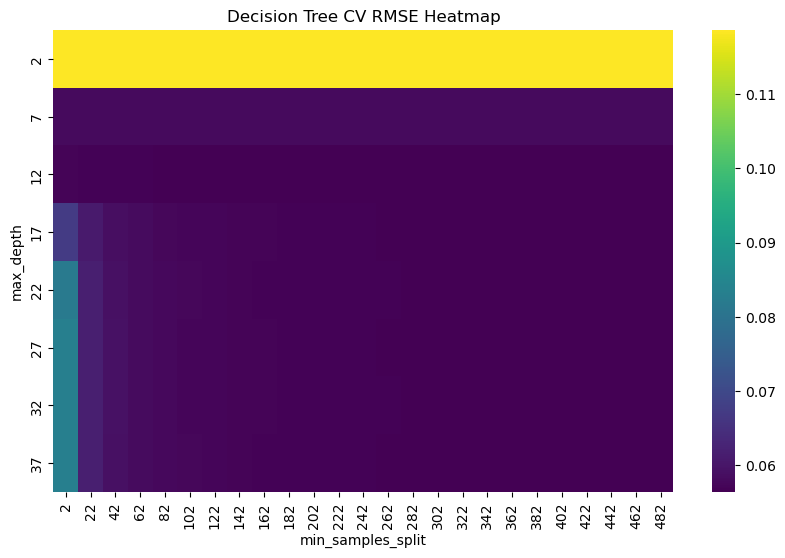

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.heatmap(rmses, 
            xticklabels=min_samples_splits,
            yticklabels=max_depths,
            cmap="viridis", 
            fmt=".2f")

plt.xlabel("min_samples_split")
plt.ylabel("max_depth")
plt.title("Decision Tree CV RMSE Heatmap")
plt.show()

In [63]:
np.unravel_index(np.argmin(rmses), rmses.shape)

(2, 21)

In [69]:
rmses[2][21]

0.05638241152007821

### Random Forst

In [72]:
from sklearn.ensemble import RandomForestRegressor

In [89]:
evaluate_model(RandomForestRegressor, max_features='sqrt')

fold: 0, rmse: 0.059148
fold: 1, rmse: 0.059490
fold: 2, rmse: 0.058975
fold: 3, rmse: 0.058966
fold: 4, rmse: 0.058859


0.05908786009723153

### Random Forst + noise, feature selection

#### Feature Selection

In [7]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error

import seaborn as sns
import numpy as np

In [9]:
X_copy = X.copy()
X_copy['noise'] = np.random.normal(0, 0.5, X.iloc[:, 0].shape)

X_noise_train, X_noise_test, y_noise_train, y_noise_test = train_test_split(X_copy, y, test_size=0.3)

In [11]:
clf = RandomForestRegressor(max_features='sqrt')
clf.fit(X_noise_train, y_noise_train)
y_noise_pred = clf.predict(X_noise_test)
root_mean_squared_error(y_noise_test, y_noise_pred)

0.05772420102039242

<Axes: xlabel='feature_importances', ylabel='feature_names'>

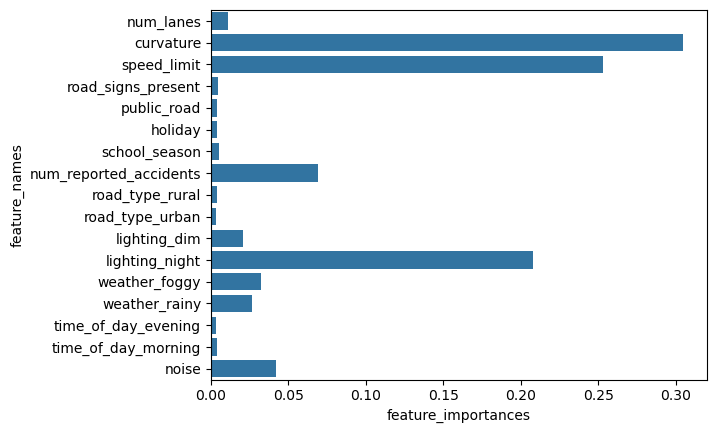

In [13]:
data = {
    "feature_importances": clf.feature_importances_,
    "feature_names": clf.feature_names_in_,
}
sns.barplot(data=data, x='feature_importances', y='feature_names')

In [15]:
df_fi = pd.DataFrame(data)
df_fi = df_fi.set_index('feature_names')
selected_features = df_fi[df_fi > df_fi.loc['noise'].iloc[0]].dropna()
selected_features

,feature_importances
feature_names,
curvature,0.304897
speed_limit,0.252762
num_reported_accidents,0.069109
lighting_night,0.207965


#### Random Forest and Selected features

In [17]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error

import seaborn as sns
import numpy as np

In [19]:
selected_feature_names = selected_features.index

X_selected = X.loc[:, selected_feature_names]

In [21]:
evaluate_model(RandomForestRegressor, X_selected, max_features='sqrt')

fold: 0, rmse: 0.070764
fold: 1, rmse: 0.070396
fold: 2, rmse: 0.070678
fold: 3, rmse: 0.070872
fold: 4, rmse: 0.070716


0.07068511307153134

### SVM + w/selection_features

In [249]:
from sklearn.svm import SVR

In [ ]:
evaluate_model(SVR, X)

### XGBoost

In [33]:
from xgboost import XGBRegressor

from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error

In [47]:
evaluate_model(XGBRegressor, X, n_estimators=1000)

fold: 0, rmse: 0.057106
fold: 1, rmse: 0.056844
fold: 2, rmse: 0.056968
fold: 3, rmse: 0.056442
fold: 4, rmse: 0.056935


0.05685897968259945

### Lightgbm

In [50]:
from lightgbm import LGBMRegressor

In [54]:
evaluate_model(LGBMRegressor, X, n_estimators=500, learning_rate=0.01)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003545 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 176
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 16
[LightGBM] [Info] Start training from score 0.352580
fold: 0, rmse: 0.056453
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004594 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 175
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 16
[LightGBM] [Info] Start training from score 0.352248
fold: 1, rmse: 0.056515
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003865 seconds.
You can set `force_row_wise=true` to

0.05656192750201241

## Parameter tuning (Optuna)

In [1]:
import optuna

### Linear Regression

In [8]:
from sklearn.linear_model import LinearRegression

### Decision Tree

In [19]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import root_mean_squared_error

import numpy as np

#### Optuna

In [21]:
kf = KFold(5, shuffle=True)

In [43]:
def objective(trial):
    max_depth = trial.suggest_int('max_depth', 2, 1000)
    min_samples_split =  trial.suggest_int('min_samples_split', 2, 500)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 200)

    clf = DecisionTreeRegressor(
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
    )
    
    rmses = []
    for train_index, test_index in kf.split(X):
        X_train = X.iloc[train_index]
        y_train = y.iloc[train_index]
        X_test = X.iloc[test_index]
        y_test = y.iloc[test_index]

        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)

        rmse = root_mean_squared_error(y_pred, y_test)
        rmses.append(rmse)

    return np.mean(rmses)

In [47]:
study = optuna.create_study()
study.optimize(objective, n_trials=150)

[I 2025-10-21 18:33:07,478] A new study created in memory with name: no-name-58dab873-7586-4277-98c4-370422071089
[I 2025-10-21 18:33:10,821] Trial 0 finished with value: 0.056667099244816485 and parameters: {'max_depth': 655, 'min_samples_split': 480, 'min_samples_leaf': 179}. Best is trial 0 with value: 0.056667099244816485.
[I 2025-10-21 18:33:14,403] Trial 1 finished with value: 0.056642423432641045 and parameters: {'max_depth': 841, 'min_samples_split': 459, 'min_samples_leaf': 64}. Best is trial 1 with value: 0.056642423432641045.
[I 2025-10-21 18:33:18,291] Trial 2 finished with value: 0.05713840811356443 and parameters: {'max_depth': 301, 'min_samples_split': 132, 'min_samples_leaf': 16}. Best is trial 1 with value: 0.056642423432641045.
[I 2025-10-21 18:33:21,949] Trial 3 finished with value: 0.05679002100605024 and parameters: {'max_depth': 332, 'min_samples_split': 261, 'min_samples_leaf': 139}. Best is trial 1 with value: 0.056642423432641045.
[I 2025-10-21 18:33:25,739] Tr

#### Full train

In [115]:
clf = DecisionTreeRegressor(**study.best_params)
clf.fit(X, y)

submission = submission_generator(clf, test_df)

### Random Forest

In [135]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import root_mean_squared_error

#### Optuna

In [137]:
kf = KFold(5, shuffle=True)

In [143]:
def objective(trials):
    n_estimators = trials.suggest_int('n_estimator', 5, 500)
    max_depth = trials.suggest_int('max_depth', 2, 500)
    min_samples_split = trials.suggest_int('min_samples_split', 1, 500)
    min_samples_leaf = trials.suggest_int('min_samples_leaf', 1, 10)
    max_features = trials.suggest_categorical('max_features', ['sqrt', 'log2'])

    clf = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        
    )
    
    rmses = []
    for train_index, test_index in kf.split(X):
        X_train = X.iloc[train_index]
        y_train = y.iloc[train_index]
        X_test = X.iloc[test_index]
        y_test = y.iloc[test_index]

        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)

        rmse = root_mean_squared_error(y_pred, y_test)
        rmses.append(rmse)

    return np.mean(rmses)

In [145]:
study = optuna.create_study()
study.optimize(objective, n_trials=100)

[I 2025-10-21 19:13:43,109] A new study created in memory with name: no-name-c2487df3-08ae-4d07-9a6d-941d4e5aa990
[I 2025-10-21 19:14:41,721] Trial 0 finished with value: 0.05863571985038685 and parameters: {'n_estimator': 84, 'max_depth': 125, 'min_samples_split': 268, 'min_samples_leaf': 8, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.05863571985038685.
[I 2025-10-21 19:16:12,806] Trial 1 finished with value: 0.05855783229788797 and parameters: {'n_estimator': 127, 'max_depth': 222, 'min_samples_split': 260, 'min_samples_leaf': 8, 'max_features': 'log2'}. Best is trial 1 with value: 0.05855783229788797.


#### Full train

### LightGBM

In [150]:
from lightgbm import LGBMRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import root_mean_squared_error

#### Optuna

In [152]:
kf = KFold(5, shuffle=True)

In [154]:
def objective(trials):
    num_leaves = trials.suggest_int('num_leaves', 4, 256)
    max_depth = trials.suggest_int('max_depth', -1, 512)
    learning_rate = trials.suggest_float('learning_rate', 0.003, 0.3)
    n_estimators = trials.suggest_int('n_estimator', 24, 1024)

    clf = LGBMRegressor(
        num_leaves=num_leaves,
        max_depth=max_depth,
        learning_rate=learning_rate,
        n_estimators=n_estimators,
    )

    rmses = []
    for train_index, test_index in kf.split(X):
        X_train = X.iloc[train_index]
        y_train = y.iloc[train_index]
        X_test = X.iloc[test_index]
        y_test = y.iloc[test_index]

        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)

        rmse = root_mean_squared_error(y_pred, y_test)
        rmses.append(rmse)

    return np.mean(rmses)

In [ ]:
study = optuna.create_study()
study.optimize(objective, n_trials=100)

[I 2025-10-21 19:25:24,988] A new study created in memory with name: no-name-a0318067-f316-46c9-a905-925ff101e236


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004294 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 171
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 16
[LightGBM] [Info] Start training from score 0.352436
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003627 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 175
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 16
[LightGBM] [Info] Start training from score 0.352466
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004388 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2025-10-21 19:25:39,324] Trial 0 finished with value: 0.05612007265756238 and parameters: {'num_leaves': 65, 'max_depth': 396, 'learning_rate': 0.08565903020702009, 'n_estimator': 487}. Best is trial 0 with value: 0.05612007265756238.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005492 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 178
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 16
[LightGBM] [Info] Start training from score 0.352288
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003867 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 172
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 16
[LightGBM] [Info] Start training from score 0.352410
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004220 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2025-10-21 19:25:46,352] Trial 1 finished with value: 0.05616703072326375 and parameters: {'num_leaves': 28, 'max_depth': 15, 'learning_rate': 0.15212418720728402, 'n_estimator': 320}. Best is trial 0 with value: 0.05612007265756238.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004438 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 172
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 16
[LightGBM] [Info] Start training from score 0.352343
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004425 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 175
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 16
[LightGBM] [Info] Start training from score 0.352502
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003474 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2025-10-21 19:25:53,017] Trial 2 finished with value: 0.05679087150170818 and parameters: {'num_leaves': 239, 'max_depth': 308, 'learning_rate': 0.29945545787910993, 'n_estimator': 163}. Best is trial 0 with value: 0.05612007265756238.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004249 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 171
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 16
[LightGBM] [Info] Start training from score 0.352336
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004116 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 173
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 16
[LightGBM] [Info] Start training from score 0.352684
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005405 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2025-10-21 19:25:58,273] Trial 3 finished with value: 0.05618176314120562 and parameters: {'num_leaves': 61, 'max_depth': 362, 'learning_rate': 0.22360933531084823, 'n_estimator': 182}. Best is trial 0 with value: 0.05612007265756238.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003819 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 169
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 16
[LightGBM] [Info] Start training from score 0.352473
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003624 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 171
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 16
[LightGBM] [Info] Start training from score 0.352219
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003854 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2025-10-21 19:26:16,539] Trial 4 finished with value: 0.05769329782020727 and parameters: {'num_leaves': 167, 'max_depth': 41, 'learning_rate': 0.2821377479349702, 'n_estimator': 574}. Best is trial 0 with value: 0.05612007265756238.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005167 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 174
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 16
[LightGBM] [Info] Start training from score 0.352441
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004175 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 172
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 16
[LightGBM] [Info] Start training from score 0.352340
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004627 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2025-10-21 19:26:23,664] Trial 5 finished with value: 0.05613796515995886 and parameters: {'num_leaves': 58, 'max_depth': 310, 'learning_rate': 0.15268584075364164, 'n_estimator': 247}. Best is trial 0 with value: 0.05612007265756238.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005681 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 173
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 16
[LightGBM] [Info] Start training from score 0.352513
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003654 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 175
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 16
[LightGBM] [Info] Start training from score 0.352442
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009290 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2025-10-21 19:26:48,412] Trial 6 finished with value: 0.05637289906514299 and parameters: {'num_leaves': 87, 'max_depth': 264, 'learning_rate': 0.15194034948901958, 'n_estimator': 580}. Best is trial 0 with value: 0.05612007265756238.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005754 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 175
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 16
[LightGBM] [Info] Start training from score 0.352406
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004360 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 173
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 16
[LightGBM] [Info] Start training from score 0.352392
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005295 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2025-10-21 19:27:12,783] Trial 7 finished with value: 0.057371754135598765 and parameters: {'num_leaves': 180, 'max_depth': 85, 'learning_rate': 0.26124799740568694, 'n_estimator': 486}. Best is trial 0 with value: 0.05612007265756238.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004731 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 174
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 16
[LightGBM] [Info] Start training from score 0.352328
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005097 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 180
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 16
[LightGBM] [Info] Start training from score 0.352463
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004280 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2025-10-21 19:27:44,559] Trial 8 finished with value: 0.05603844107634207 and parameters: {'num_leaves': 140, 'max_depth': 303, 'learning_rate': 0.01760958646507478, 'n_estimator': 545}. Best is trial 8 with value: 0.05603844107634207.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004153 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 172
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 16
[LightGBM] [Info] Start training from score 0.352472
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005361 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 172
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 16
[LightGBM] [Info] Start training from score 0.352356
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004007 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2025-10-21 19:28:07,398] Trial 9 finished with value: 0.057765884675277115 and parameters: {'num_leaves': 129, 'max_depth': 247, 'learning_rate': 0.2645592301838523, 'n_estimator': 865}. Best is trial 8 with value: 0.05603844107634207.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004237 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 173
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 16
[LightGBM] [Info] Start training from score 0.352392
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003916 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 170
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 16
[LightGBM] [Info] Start training from score 0.352381
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003143 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2025-10-21 19:28:53,096] Trial 10 finished with value: 0.056042843796101326 and parameters: {'num_leaves': 122, 'max_depth': 507, 'learning_rate': 0.010389304616184007, 'n_estimator': 989}. Best is trial 8 with value: 0.05603844107634207.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004568 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 174
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 16
[LightGBM] [Info] Start training from score 0.352424
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003693 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 173
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 16
[LightGBM] [Info] Start training from score 0.352347
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004589 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2025-10-21 19:29:37,279] Trial 11 finished with value: 0.0560490771547306 and parameters: {'num_leaves': 124, 'max_depth': 498, 'learning_rate': 0.008387668456637805, 'n_estimator': 1015}. Best is trial 8 with value: 0.05603844107634207.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004051 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 175
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 16
[LightGBM] [Info] Start training from score 0.352691
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005939 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 175
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 16
[LightGBM] [Info] Start training from score 0.352372
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004407 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2025-10-21 19:30:27,907] Trial 12 finished with value: 0.05611359090484206 and parameters: {'num_leaves': 179, 'max_depth': 493, 'learning_rate': 0.005391704597620842, 'n_estimator': 826}. Best is trial 8 with value: 0.05603844107634207.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005396 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 173
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 16
[LightGBM] [Info] Start training from score 0.352416
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003798 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 175
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 16
[LightGBM] [Info] Start training from score 0.352190
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004780 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2025-10-21 19:30:57,816] Trial 13 finished with value: 0.05636697688737866 and parameters: {'num_leaves': 228, 'max_depth': 170, 'learning_rate': 0.06142578288681171, 'n_estimator': 737}. Best is trial 8 with value: 0.05603844107634207.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004284 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 171
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 16
[LightGBM] [Info] Start training from score 0.352526
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004377 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 175
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 16
[LightGBM] [Info] Start training from score 0.352384
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004532 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2025-10-21 19:30:59,705] Trial 14 finished with value: 0.06629025042520995 and parameters: {'num_leaves': 108, 'max_depth': 386, 'learning_rate': 0.061430967817849, 'n_estimator': 24}. Best is trial 8 with value: 0.05603844107634207.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003727 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 172
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 16
[LightGBM] [Info] Start training from score 0.352357
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003821 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 173
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 16
[LightGBM] [Info] Start training from score 0.352433
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004475 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2025-10-21 19:31:34,881] Trial 15 finished with value: 0.05656592407022979 and parameters: {'num_leaves': 154, 'max_depth': 168, 'learning_rate': 0.089909136344979, 'n_estimator': 1018}. Best is trial 8 with value: 0.05603844107634207.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004373 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 172
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 16
[LightGBM] [Info] Start training from score 0.352330
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003711 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 170
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 16
[LightGBM] [Info] Start training from score 0.352562
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003787 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2025-10-21 19:32:04,820] Trial 16 finished with value: 0.05614144780258172 and parameters: {'num_leaves': 215, 'max_depth': 445, 'learning_rate': 0.03609776689408274, 'n_estimator': 700}. Best is trial 8 with value: 0.05603844107634207.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005781 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 173
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 16
[LightGBM] [Info] Start training from score 0.352516
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004971 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 172
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 16
[LightGBM] [Info] Start training from score 0.352498
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005260 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2025-10-21 19:32:11,799] Trial 17 finished with value: 0.05630421259130458 and parameters: {'num_leaves': 9, 'max_depth': 161, 'learning_rate': 0.11103082888171911, 'n_estimator': 410}. Best is trial 8 with value: 0.05603844107634207.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004144 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 167
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 16
[LightGBM] [Info] Start training from score 0.352434
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003597 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 176
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 16
[LightGBM] [Info] Start training from score 0.352238
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003844 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2025-10-21 19:32:42,169] Trial 18 finished with value: 0.05789794498115438 and parameters: {'num_leaves': 200, 'max_depth': 446, 'learning_rate': 0.20902992469726667, 'n_estimator': 891}. Best is trial 8 with value: 0.05603844107634207.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003472 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 173
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 16
[LightGBM] [Info] Start training from score 0.352317
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005105 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 174
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 16
[LightGBM] [Info] Start training from score 0.352506
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005256 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2025-10-21 19:33:07,526] Trial 19 finished with value: 0.056108839285743395 and parameters: {'num_leaves': 148, 'max_depth': 438, 'learning_rate': 0.03971098104209781, 'n_estimator': 673}. Best is trial 8 with value: 0.05603844107634207.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004072 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 174
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 16
[LightGBM] [Info] Start training from score 0.352298
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003618 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 169
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 16
[LightGBM] [Info] Start training from score 0.352390
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004071 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2025-10-21 19:33:29,734] Trial 20 finished with value: 0.056466766018415916 and parameters: {'num_leaves': 97, 'max_depth': 227, 'learning_rate': 0.11751602564200081, 'n_estimator': 928}. Best is trial 8 with value: 0.05603844107634207.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004094 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 171
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 16
[LightGBM] [Info] Start training from score 0.352496
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004966 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 172
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 16
[LightGBM] [Info] Start training from score 0.352192
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004349 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2025-10-21 19:34:21,010] Trial 21 finished with value: 0.05612057245139106 and parameters: {'num_leaves': 115, 'max_depth': 485, 'learning_rate': 0.004886114403670498, 'n_estimator': 1004}. Best is trial 8 with value: 0.05603844107634207.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005519 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 172
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 16
[LightGBM] [Info] Start training from score 0.352265
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003673 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 168
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 16
[LightGBM] [Info] Start training from score 0.352234
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004407 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2025-10-21 19:34:53,113] Trial 22 finished with value: 0.05609085899674425 and parameters: {'num_leaves': 140, 'max_depth': 504, 'learning_rate': 0.03125904476417992, 'n_estimator': 791}. Best is trial 8 with value: 0.05603844107634207.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005637 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 175
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 16
[LightGBM] [Info] Start training from score 0.352444
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004065 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 175
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 16
[LightGBM] [Info] Start training from score 0.352372
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004895 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2025-10-21 19:35:46,872] Trial 23 finished with value: 0.056125919842728855 and parameters: {'num_leaves': 119, 'max_depth': 324, 'learning_rate': 0.005174472574243868, 'n_estimator': 953}. Best is trial 8 with value: 0.05603844107634207.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004803 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 171
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 16
[LightGBM] [Info] Start training from score 0.352273
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005439 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 166
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 16
[LightGBM] [Info] Start training from score 0.352545
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003970 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2025-10-21 19:36:08,733] Trial 24 finished with value: 0.05613682958107974 and parameters: {'num_leaves': 77, 'max_depth': 419, 'learning_rate': 0.05758043694758251, 'n_estimator': 767}. Best is trial 8 with value: 0.05603844107634207.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004113 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 173
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 16
[LightGBM] [Info] Start training from score 0.352483
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004040 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 176
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 16
[LightGBM] [Info] Start training from score 0.352236
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003814 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2025-10-21 19:36:34,163] Trial 25 finished with value: 0.05606166334395204 and parameters: {'num_leaves': 133, 'max_depth': 511, 'learning_rate': 0.027429808174928294, 'n_estimator': 651}. Best is trial 8 with value: 0.05603844107634207.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004484 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 172
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 16
[LightGBM] [Info] Start training from score 0.352331
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005359 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 173
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 16
[LightGBM] [Info] Start training from score 0.352535
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003865 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2025-10-21 19:36:49,543] Trial 26 finished with value: 0.05618228326459799 and parameters: {'num_leaves': 159, 'max_depth': 356, 'learning_rate': 0.08488763225882441, 'n_estimator': 407}. Best is trial 8 with value: 0.05603844107634207.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004188 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 175
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 16
[LightGBM] [Info] Start training from score 0.352296
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003937 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 177
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 16
[LightGBM] [Info] Start training from score 0.352556
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004751 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2025-10-21 19:37:12,410] Trial 27 finished with value: 0.056918476142230126 and parameters: {'num_leaves': 101, 'max_depth': 474, 'learning_rate': 0.18605545341671426, 'n_estimator': 937}. Best is trial 8 with value: 0.05603844107634207.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003875 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 172
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 16
[LightGBM] [Info] Start training from score 0.352213
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003908 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 170
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 16
[LightGBM] [Info] Start training from score 0.352408
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004264 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2025-10-21 19:38:04,237] Trial 28 finished with value: 0.056144361388596756 and parameters: {'num_leaves': 201, 'max_depth': 463, 'learning_rate': 0.02556490325085705, 'n_estimator': 1024}. Best is trial 8 with value: 0.05603844107634207.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004278 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 171
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 16
[LightGBM] [Info] Start training from score 0.352473
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004073 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 171
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 16
[LightGBM] [Info] Start training from score 0.352388
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004452 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2025-10-21 19:38:22,835] Trial 29 finished with value: 0.0561364323171434 and parameters: {'num_leaves': 47, 'max_depth': 424, 'learning_rate': 0.07638882488574578, 'n_estimator': 857}. Best is trial 8 with value: 0.05603844107634207.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004050 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 170
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 16
[LightGBM] [Info] Start training from score 0.352238
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004299 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 174
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 16
[LightGBM] [Info] Start training from score 0.352247
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004179 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2025-10-21 19:38:38,362] Trial 30 finished with value: 0.05625537281108077 and parameters: {'num_leaves': 85, 'max_depth': 380, 'learning_rate': 0.11902259295502632, 'n_estimator': 609}. Best is trial 8 with value: 0.05603844107634207.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003912 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 171
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 16
[LightGBM] [Info] Start training from score 0.352473
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004398 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 173
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 16
[LightGBM] [Info] Start training from score 0.352452
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003646 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2025-10-21 19:39:03,049] Trial 31 finished with value: 0.05604183252824883 and parameters: {'num_leaves': 131, 'max_depth': 410, 'learning_rate': 0.021841480687821706, 'n_estimator': 479}. Best is trial 8 with value: 0.05603844107634207.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003778 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 173
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 16
[LightGBM] [Info] Start training from score 0.352365
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004279 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 175
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 16
[LightGBM] [Info] Start training from score 0.352422
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004380 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2025-10-21 19:39:21,949] Trial 32 finished with value: 0.05608927575628201 and parameters: {'num_leaves': 125, 'max_depth': 406, 'learning_rate': 0.049443822697090044, 'n_estimator': 504}. Best is trial 8 with value: 0.05603844107634207.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003958 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 170
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 16
[LightGBM] [Info] Start training from score 0.352218
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003502 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 173
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 16
[LightGBM] [Info] Start training from score 0.352429
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004610 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2025-10-21 19:39:45,471] Trial 33 finished with value: 0.056040728538950445 and parameters: {'num_leaves': 143, 'max_depth': 335, 'learning_rate': 0.018086784162432527, 'n_estimator': 405}. Best is trial 8 with value: 0.05603844107634207.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004493 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 178
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 16
[LightGBM] [Info] Start training from score 0.352183
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003953 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 171
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 16
[LightGBM] [Info] Start training from score 0.352261
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003850 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2025-10-21 19:40:08,028] Trial 34 finished with value: 0.05604143553567757 and parameters: {'num_leaves': 172, 'max_depth': 282, 'learning_rate': 0.023632199562509504, 'n_estimator': 347}. Best is trial 8 with value: 0.05603844107634207.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003685 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 170
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 16
[LightGBM] [Info] Start training from score 0.352339
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005402 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 173
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 16
[LightGBM] [Info] Start training from score 0.352515
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003565 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2025-10-21 19:40:23,765] Trial 35 finished with value: 0.056121579230787665 and parameters: {'num_leaves': 168, 'max_depth': 264, 'learning_rate': 0.07526818637961666, 'n_estimator': 356}. Best is trial 8 with value: 0.05603844107634207.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004139 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 172
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 16
[LightGBM] [Info] Start training from score 0.352554
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003766 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 173
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 16
[LightGBM] [Info] Start training from score 0.352350
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004488 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2025-10-21 19:40:43,200] Trial 36 finished with value: 0.05605220113257572 and parameters: {'num_leaves': 174, 'max_depth': 350, 'learning_rate': 0.020926752000070742, 'n_estimator': 290}. Best is trial 8 with value: 0.05603844107634207.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004986 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 175
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 16
[LightGBM] [Info] Start training from score 0.352380
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004734 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 172
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 16
[LightGBM] [Info] Start training from score 0.352552
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004279 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2025-10-21 19:40:59,982] Trial 37 finished with value: 0.05631000018685722 and parameters: {'num_leaves': 189, 'max_depth': 283, 'learning_rate': 0.1010893584382897, 'n_estimator': 458}. Best is trial 8 with value: 0.05603844107634207.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005347 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 173
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 16
[LightGBM] [Info] Start training from score 0.352155
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004540 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 176
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 16
[LightGBM] [Info] Start training from score 0.352389
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003827 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2025-10-21 19:41:09,446] Trial 38 finished with value: 0.05604193437231023 and parameters: {'num_leaves': 143, 'max_depth': 217, 'learning_rate': 0.05427582161056233, 'n_estimator': 211}. Best is trial 8 with value: 0.05603844107634207.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004134 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 173
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 16
[LightGBM] [Info] Start training from score 0.352293
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004927 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 171
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 16
[LightGBM] [Info] Start training from score 0.352375
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004238 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[I 2025-10-21 19:41:36,933] Trial 39 finished with value: 0.056143098012558304 and parameters: {'num_leaves': 245, 'max_depth': 333, 'learning_rate': 0.04273995067570475, 'n_estimator': 544}. Best is trial 8 with value: 0.05603844107634207.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004984 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 173
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 16
[LightGBM] [Info] Start training from score 0.352469
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005450 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 174
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 16
[LightGBM] [Info] Start training from score 0.352359
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003953 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

#### Full train